In [1]:
import pickle
import keras
import numpy as np
import tensorflow as tf
from sequence_attention import DataGeneratorPickle, SeqAttModel
from sequence_attention.utils import preprocess_data_pickle, select_data_pickle 
from sequence_attention.SeqVisualUnit import create_mat_plot
from config import Config

Using TensorFlow backend.
/home/nuria/.local/share/virtualenvs/Read2Pheno-YfFcwwiN/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nuria/.local/share/virtualenvs/Read2Pheno-YfFcwwiN/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nuria/.local/share/virtualenvs/Read2Pheno-YfFcwwiN/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np

### Preprocess the data

There are three different ways to prepare the data: 

2. convert each fna file to a pickle file with a python dictionary data structure (key is the unique sequence identifier and value is the actual sequence). Then the data generator can load a pickle file and look up for a read and construct a batch of data.
3. The fastest way is, of course, training and testing your model without using the data generator. Instead, permitted by the computer memory, users can load all the training data in memory and directly fit the model. In this way, there will be no additional I/O process. 

When designing this tool, we don't make any assumption on the computer memory at the user's disposal, therefore, this demo focuses on the second preprocessing method since it covers the most use cases. But if the users do have enough memory, they are more than welcome to fit the model without the generator function.

In [2]:
opt = Config() # cargar configuración

In [3]:
# segunda técnica de pre-procesado
preprocess_data_pickle(opt) # obtener los pickle de CD y Not-CD, label_dict, sample_to_label y read_meta_data

08-Jun-22 16:49:21 - Processing raw data: 0.0% completed.
08-Jun-22 16:49:21 - Processing raw data: 10.0% completed.
08-Jun-22 16:49:21 - Processing raw data: 20.0% completed.
08-Jun-22 16:49:21 - Processing raw data: 30.0% completed.
08-Jun-22 16:49:21 - Processing raw data: 40.0% completed.
08-Jun-22 16:49:21 - Processing raw data: 50.0% completed.
08-Jun-22 16:49:22 - Processing raw data: 60.0% completed.
08-Jun-22 16:49:22 - Processing raw data: 70.0% completed.
08-Jun-22 16:49:22 - Processing raw data: 80.0% completed.
08-Jun-22 16:49:22 - Processing raw data: 90.0% completed.
08-Jun-22 16:49:22 - Processing raw data: 100.0% completed.
08-Jun-22 16:49:22 - Processing raw data: 110.0% completed.


In [3]:
select_data_pickle(opt) # obtener sequence_list y sequence_list_selected

sequence_list   done
sequence_list_selected   done


### Load metadata and initialize the deep learning model

In [4]:
import pickle

# cargar os pickle cos datos pre-procesados no paso anterior
label_dict = pickle.load(open('{}/label_dict.pkl'.format(opt.out_dir), 'rb'))
sample_to_label, read_meta_data = pickle.load(open('{}/meta_data.pkl'.format(opt.out_dir), 'rb'))
#sequence_list = pickle.load(open('{}/sequence_list.pkl'.format(opt.out_dir), 'rb'))
sequence_list = pickle.load(open('{}/sequence_list_selected.pkl'.format(opt.out_dir), 'rb'))

# crear o modelo
seq_att_model = SeqAttModel(opt)

09-Jun-22 12:43:12 - Model initialized.


In [5]:
label_dict # encoded labels

{'CD': 0, 'Not-CD': 1}

In [6]:
#sample_to_label # basicamente meta_data.csv
len(sample_to_label)

1359

In [7]:
#read_meta_data # dict cos ids das secuencias de cada mostra (id mostra: [ids secuencias da mostra])
list(read_meta_data.keys())[0]   # primeira mostra
#list(read_meta_data.values())[0] # secuencias da primeira mostra

1359

In [5]:
#sequence_list[0:20] # secuencias das mostras (.pickle da mostra, identificador da secuencia)

from collections import Counter
num_samples = Counter([x for (x,y) in sequence_list])

print("len(num_samples) : " + str(len(num_samples)))
print(num_samples)

len(num_samples) : 40
Counter({'../crohns_disease/results/CNNclassifier/CD/ERR1369779.pkl': 500, '../crohns_disease/results/CNNclassifier/Not-CD/ERR1369439.pkl': 500, '../crohns_disease/results/CNNclassifier/Not-CD/ERR1368923.pkl': 500, '../crohns_disease/results/CNNclassifier/CD/ERR1369717.pkl': 500, '../crohns_disease/results/CNNclassifier/CD/ERR1369834.pkl': 500, '../crohns_disease/results/CNNclassifier/CD/ERR1369302.pkl': 500, '../crohns_disease/results/CNNclassifier/CD/ERR1369859.pkl': 500, '../crohns_disease/results/CNNclassifier/CD/ERR1370174.pkl': 500, '../crohns_disease/results/CNNclassifier/CD/ERR1369149.pkl': 500, '../crohns_disease/results/CNNclassifier/CD/ERR1370149.pkl': 500, '../crohns_disease/results/CNNclassifier/Not-CD/ERR1369665.pkl': 500, '../crohns_disease/results/CNNclassifier/Not-CD/ERR1368961.pkl': 500, '../crohns_disease/results/CNNclassifier/CD/ERR1370073.pkl': 500, '../crohns_disease/results/CNNclassifier/Not-CD/ERR1369412.pkl': 500, '../crohns_disease/result

In [ ]:
# mostra en formato .pickle (identificador da secuencia, secuencia sen codificar)
sample_pickle = pickle.load(open('../crohns_disease/results/CNNclassifier/Not-CD/ERR1368889.pkl'.format(opt.out_dir), 'rb'))
sample_pickle

In [ ]:
seq_att_model.model.summary() 

### Prepare the data generator for training and testing

In [6]:
generator = DataGeneratorPickle(sequence_list, sample_to_label, label_dict, 
                                   dim=(opt.SEQLEN,opt.BASENUM), batch_size=opt.batch_size, shuffle=opt.shuffle)

In [7]:
X, y = generator.getalldata() # X = secuencias one-hot encoded, y = labels encoded

In [8]:
#X
X.shape  # 500*39+4 reads, 100 sequence len, 4 bases

(19504, 100, 4)

In [9]:
#y
y.shape # 500*39+4

(19504,)

### Train and evaluate the model with Cross Validation

In [10]:
seq_att_model.tune_and_eval(X, y, label_dict)


 Evaluation on a new fold is now get started ..
Train on 17553 samples, validate on 1951 samples
Epoch 1/10
17553/17553 [==============================] - 461s 26ms/step - loss: 0.6745 - val_loss: 0.6442
Epoch 2/10
17553/17553 [==============================] - 484s 28ms/step - loss: 0.6297 - val_loss: 0.6277
Epoch 3/10
17553/17553 [==============================] - 474s 27ms/step - loss: 0.6140 - val_loss: 0.6391
Epoch 4/10
17553/17553 [==============================] - 467s 27ms/step - loss: 0.6061 - val_loss: 0.6243
Epoch 5/10
17553/17553 [==============================] - 475s 27ms/step - loss: 0.5971 - val_loss: 0.6132
Epoch 6/10
17553/17553 [==============================] - 479s 27ms/step - loss: 0.5959 - val_loss: 0.6317
Epoch 7/10
17553/17553 [==============================] - 478s 27ms/step - loss: 0.5912 - val_loss: 0.6021
Epoch 8/10
17553/17553 [==============================] - 458s 26ms/step - loss: 0.5871 - val_loss: 0.6459
Epoch 9/10
17553/17553 [======================

Train on 17554 samples, validate on 1950 samples
Epoch 1/10
17554/17554 [==============================] - 449s 26ms/step - loss: 0.6573 - val_loss: 0.7338
Epoch 2/10
17554/17554 [==============================] - 456s 26ms/step - loss: 0.6223 - val_loss: 0.6069
Epoch 3/10
17554/17554 [==============================] - 456s 26ms/step - loss: 0.6068 - val_loss: 0.6399
Epoch 4/10
17554/17554 [==============================] - 469s 27ms/step - loss: 0.6026 - val_loss: 0.6051
Epoch 5/10
17554/17554 [==============================] - 450s 26ms/step - loss: 0.5953 - val_loss: 0.6039
Epoch 6/10
17554/17554 [==============================] - 481s 27ms/step - loss: 0.5919 - val_loss: 0.6263
Epoch 7/10
17554/17554 [==============================] - 548s 31ms/step - loss: 0.5865 - val_loss: 0.6410
Epoch 8/10
17554/17554 [==============================] - 654s 37ms/step - loss: 0.5844 - val_loss: 0.6071
Epoch 9/10
17554/17554 [==============================] - 772s 44ms/step - loss: 0.5796 - val_l

### Confussion matrix

10-Jun-22 10:24:56 - font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
10-Jun-22 10:25:01 - font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
10-Jun-22 10:25:01 - font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
10-Jun-22 10:25:35 - font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
10-Jun-22 10:25:35 - font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.


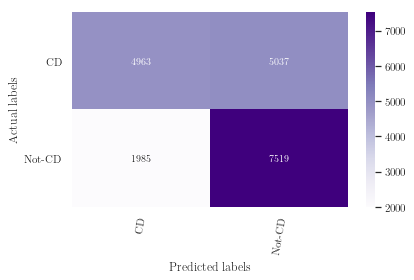

<Figure size 432x288 with 0 Axes>

In [11]:
[labels_alphanum, conf, p_micro, r_micro, f1_micro, p_macro, r_macro, f1_macro, accuracy, roc_auc, (loss_values, val_loss_values)]=pickle.load(open('../crohns_disease/results/CNNclassifier/all_results.pkl', "rb"))
#labels_alphanum.reverse()
create_mat_plot(conf, labels_alphanum, '', '../crohns_disease/results/CNNclassifier/confusion_matrix', 'Predicted labels' ,'Actual labels', cmap='Purples', filetype='pdf', rx=80, ry=0, font_s=15)

In [25]:
pickle.dump(X, open('{}/X.pkl'.format(opt.out_dir), 'wb'))
pickle.dump(y, open('{}/y.pkl'.format(opt.out_dir), 'wb'))